In [5]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" 
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers funciton

In [6]:
folder = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam"

HEADER_LEN = 152 
X_DIM = 480
Y_DIM = 640

frame_rate = 92.59
shutter_delay = 0.01 # second
interestd_position = 4 # mm
pixel_size = 0.00108 
beamwidth = 88200
# exposure time = 5ms

gold_melting_W = {
    '103.8': 98.5,
    '17.6': 64,
    '35.3': 73.5,
    '8.8': 61.5,
    '88.2': 93.5
}

In [10]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files, used_frame_num)
back = back_intensity_list
power_list = get_powers(all_files)

[3, 21, 10, 42, 4]


In [12]:
velocity_list

[['103.8'], ['17.6'], ['35.3'], ['8.8'], ['88.2']]

In [150]:
gold_melting_W = {
    '103.8': 98.5,
    '17.6': 64,
    '35.3': 73.5,
    '8.8': 61.5,
    '88.2': 93.5
}

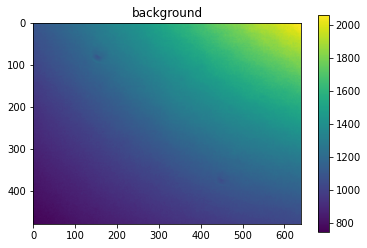

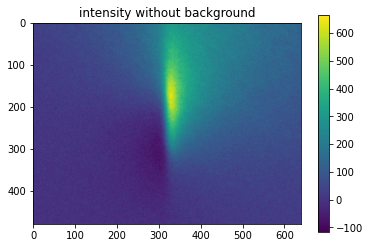

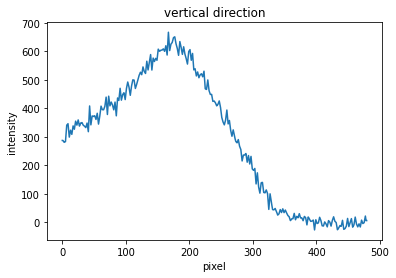

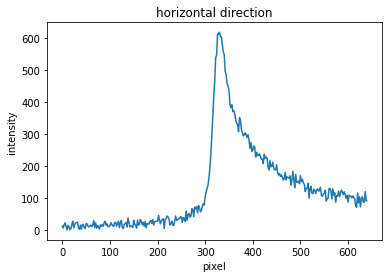

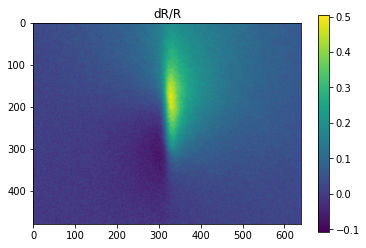

In [14]:
image = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0210_2023_newbeam/17.6mm_per_sec/18mm_85W_021.raw"
whole = get_blue(image)
# zoomin = get_bright(whole)
b_whole = back[1]
# fig 1: background
sc = plt.imshow(b_whole)
plt.colorbar(sc)
plt.title("background")
plt.show()
# fig 2: intensity without background
sc = plt.imshow(whole-b_whole)
plt.colorbar(sc)
plt.title("intensity without background")
plt.show()
# fig 3: vertical direction trend
plt.plot((whole-b_whole)[:,330])
plt.title("vertical direction")
plt.xlabel("pixel")
plt.ylabel("intensity")
plt.show()
# fig 4: horizontal direction trend
plt.plot((whole-b_whole)[180,:])
plt.title("horizontal direction")
plt.xlabel("pixel")
plt.ylabel("intensity")
plt.show()
# fig 5: dR/R intensity
sc = plt.imshow((whole - b_whole)/b_whole)
plt.colorbar(sc)
plt.title("dR/R")
plt.show()

In [151]:
v_list = ['103.8', '17.6', '35.3', '8.8', '88.2']
Dict_1 = dict((k, fivemm_files[k][3:]) for k in v_list) # not included 0W files
back_intensity_list_1 = []
for key in fivemm_files:
    if key in v_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_1.append(back_intensity_list[index])
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_1[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1.append(con)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [152]:
power_used = {
        '103.8':[65+5*p for p in range(0,len(dRoverR_1[v_list.index('103.8')]),1)], 
        '17.6':[30+5*p for p in range(0,len(dRoverR_1[v_list.index('17.6')]),1)], 
        '35.3':[40+5*p for p in range(0,len(dRoverR_1[v_list.index('35.3')]),1)],
        '8.8':[30+5*p for p in range(0,len(dRoverR_1[v_list.index('8.8')]),1)], 
        '88.2':[55+5*p for p in range(0,len(dRoverR_1[v_list.index('88.2')]),1)],
          
        }


In [ ]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
                
        #convert the frame number to position
        #x = [(frame-2.7)*int(key)/92.59 for frame in range(1,len(temp_list)+1)] 
        
        x = [frame for frame in range(0,len(dR_list))] 
        
        
        plt.plot(x, dR_list, marker="o")
        
        #limit temperature to 1500C
        #plt.ylim(0,1500)
        
        #limit position to 1-10mm
        #plt.xlim(0,5)

    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_dRoverR_vs_frame/{}mmpersec.png".format(key), format="PNG")
    plt.close()

In [153]:
for i, v in enumerate(list(gold_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()

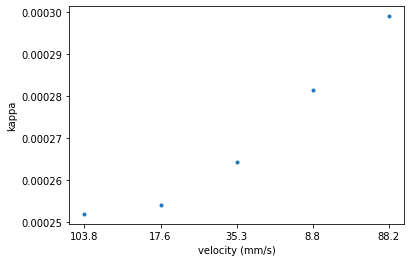

In [154]:
v_list = ['103.8', '17.6', '35.3', '8.8', '88.2']

# Dict_gold = dict((k, fivemm_files[k][3:]) for k in v_list)
kappa_gold = []
for i, v in enumerate(list(gold_melting_W.keys())):
    power = [float(j) for j in power_used[v]][:-1]
    y = dRoverR_1[i][:-1]
    popt, pcov = curve_fit(expo, power, y, p0 = [1, 0.00000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power, y, '.')
    y_pred = [expo(j, *popt) for j in power]
    plt.plot(power, y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(gold_melting_W[v], *popt)
    gold_m = 1064
    dT = gold_m - 21
    kappa = f / dT
    kappa_gold.append(kappa)

    temp_pred = [expo(j, *popt)/kappa for j in power_used[v][:-1]]
    plt.plot(power, temp_pred)
    plt.plot(gold_melting_W[v], 1064, marker="o", color = 'g', label='gold')
    plt.legend(loc="upper left")
    plt.xlabel("power")
    plt.ylabel("temperature")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_gold_fit/{}mm.png".format(v), format="PNG")
    plt.close()
    
Dict_kappa_gold = dict(zip(list(gold_melting_W.keys()),kappa_gold))

plt.plot(list(gold_melting_W.keys()), kappa_gold, '.')
plt.xlabel("velocity (mm/s)")
plt.ylabel("kappa")
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0210_kappa.png", format="PNG")

In [155]:
peak_temp = []
for i, v in enumerate(list(gold_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_gold[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(gold_melting_W.keys()),peak_temp))

In [156]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(gold_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(float(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 1.61728573e-01 -7.31055970e-02  1.36312105e+01 -6.52012440e-01
 -1.53918472e+02  1.81344481e+00  2.11366601e-01  8.26753493e-03]
1669.708584585521


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_27826/1048899720.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [157]:
parameters_T = np.array([ 1.61728573e-01, -7.31055970e-02 , 1.36312105e+01, -6.52012440e-01,
 -1.53918472e+02 , 1.81344481e+00 , 2.11366601e-01 , 8.26753493e-03])

def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_T
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])

In [158]:
get_power(88200/35.3, 1410)

86.67815490907257

In [159]:
%matplotlib
import matplotlib.pyplot as plt

for velocity in np.unique(y_data):
    mask = y_data == velocity
    plt.plot(x_data[mask], z_data[mask], label = str(round(np.exp(y_data[mask][0])))+'mm/s')
    plt.xlabel("power")
    plt.ylabel("peak temperature")
    plt.legend()

Using matplotlib backend: MacOSX


# lateral temperature profile

In [160]:
dRoverR_line = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_laterial_fit_line(file, back_intensity_list[i], two_lorentz)
        con.append(val)
    dRoverR_line.append(con)
    

temp_line = []    
for i, v in enumerate(list(Dict_1.keys())):
    con_2 = []
    velo = dRoverR_line[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_gold[v])
        con_2.append(temp)
    temp_line.append(con_2)
    
parameters = []
for i, v in enumerate(list(Dict_1.keys())):
    con_3 = []
    velo = temp_line[i]
    for t in velo:
        # [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
        par = fit(two_lorentz, t)
        con_3.append(par)
    parameters.append(con_3)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### 35.3mm/s, 98W

In [170]:
a,b,c,d = fit(two_lorentz, temp_line[2][9][:-26])
plt.plot(temp_line[2][9][:-26])
# plt.plot(np.linspace(0,149,150),temp_line[0][5] )
plt.plot(np.linspace(0,149,150), two_lorentz(np.linspace(0,149,150),a,b,c,d))
plt.xlabel("pixel")
plt.ylabel("Temperature (Celsius)")

Text(0, 0.5, 'Temperature (Celsius)')

In [171]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)


plt.plot(np.linspace(-300,400,700), two_lorentz(np.linspace(-300,400,700),a,b,c,d))
annot_max(np.linspace(-300,400,700), two_lorentz(np.linspace(-300,400,700),a,b,c,d))
plt.xlabel("pixel")
plt.ylabel("Temperature (Celsius)")

Text(0, 0.5, 'Temperature (Celsius)')

## Lateral

In [80]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

beamwidth = 88200

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g


points_1 = []
points_2 = []

for i, v in enumerate(list(gold_melting_W.keys())):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / float(v))] * len(Dict_peak_temp[v])
    sigma1 = [abs(el[2]) for el in parameters[i]]
    sigma2 = [abs(el[3]) for el in parameters[i]]
    point1 = [list(x) for x in zip(*[P,tau,sigma1,T])]
    points_1.append(point1)
    point2 = [list(x) for x in zip(*[P,tau,sigma2,T])]
    points_2.append(point2)

    
x_data = []
y_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # tau
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[3]) # Tpeak
        

for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
        
        
x_data, y_data, z_data_1, z_data_2, t_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data)

# focus on temperature > 400
mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]


# remove outliers
mask_2 = z_data_1 < 300
x_data = x_data[mask_2]
y_data = y_data[mask_2]
z_data_1 = z_data_1[mask_2]
z_data_2 = z_data_2[mask_2]


parameters_1, covariance_1 = curve_fit(function, [x_data, y_data], z_data_1,  maxfev=1000000)
parameters_2, covariance_2 = curve_fit(function, [x_data, y_data], z_data_2,  maxfev=1000000)

print(parameters_1)
print(parameters_2)

model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z1 = function(np.array([X, Y]), *parameters_1)
Z2 = function(np.array([X, Y]), *parameters_2)

z_predicted_1 = function([x_data, y_data], *parameters_1)
z_predicted_2 = function([x_data, y_data], *parameters_2)

differences_1 = np.subtract(z_data_1, z_predicted_1)
differences_2 = np.subtract(z_data_2, z_predicted_2)

squared_differences_1 = np.square(differences_1)
squared_differences_2 = np.square(differences_2)

mse_1 = squared_differences_1.mean()
mse_2 = squared_differences_2.mean()
print(mse_1)
print(mse_2)

Using matplotlib backend: MacOSX
[ 5.54845969e+01  9.92441056e-01  5.53385540e+01 -2.77886991e-03
 -2.93391120e+03  1.35038641e+02 -2.36674644e+03]
[-1.25390468e-04  8.68020880e-01 -1.42943789e-04  5.95222456e-01
 -2.59288854e-01 -3.08499848e+01  2.77920909e+02]
619.5630729862112
198.7199204950966


In [79]:
f1 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes1 = Axes3D(f1)

axes1.plot_surface(X, Y, Z1, cmap=cm.hot, alpha=0.2)
axes1.scatter(x_data, y_data, z_data_1, s=500)

axes1.set_title('Scatter Plot')
axes1.set_xlabel('power - W', fontsize=30, labelpad=40)
axes1.set_ylabel('tau',fontsize=30, labelpad=40)
axes1.set_zlabel('sigma1', fontsize=30, labelpad=40)

axes1.tick_params(axis='both', which='major', labelsize=30)
 
plt.show()
print(mse_1)

30805296146983.305


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_27826/2512510063.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes1 = Axes3D(f1)


In [76]:
f2 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes2 = Axes3D(f2)

axes2.plot_surface(X, Y, Z2, cmap=cm.hot, alpha=0.2)
axes2.scatter(x_data, y_data, z_data_2, s=500)

axes2.set_title('Scatter Plot')
axes2.set_xlabel('power - W', fontsize=30, labelpad=40)
axes2.set_ylabel('tau',fontsize=30, labelpad=40)
axes2.set_zlabel('sigma2', fontsize=30, labelpad=40)

axes2.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse_2)

198.7199204950966


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_27826/3592995763.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes2 = Axes3D(f2)


In [77]:
print(max(z_data_1))
print(min(z_data_1))
print(max(z_data_2))
print(min(z_data_2))

294.4712617090524
153.00876818898655
75.59850519218632
0.19500885305378876
